---
title: "Single-cell RNA-seq Quality Control Metrics"
author: "Your Name"
date: "2025-02-24"
execute:
  echo: false
  enabled: true
format: 
  html:
    embed-resources: true
params:
  adata_file: "path/to/your/anndata/file.h5ad"
  sample_field: "Sample_ID"
  output_format: "html"
  percent_mito_field: "pct_counts_mito"
  percent_ribo_field: "pct_counts_ribo"
---

In [1]:
adata_file = "path/to/your/anndata/file.h5ad"
sample_field = "Sample_ID"
output_format = "html"
percent_mito_field = "pct_counts_mito"
percent_ribo_field = "pct_counts_ribo"
ribo_field = "ribo"
mito_field = "mito"
gene_symbols_field = "gene_name"
plot_size = None
label_font_size = None

In [2]:
# Injected Parameters
adata_file = "../../decoupler/test-data/mito_counted_anndata.h5ad"
sample_field = "batch"
percent_mito_field = "pct_counts_mito"
gene_symbols_field = "Symbol"


In [3]:
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def general_quality_plot(adata, sample_field, percent_mito_field, percent_ribo_field):
    fields = [
        "n_genes_by_counts",
        "total_counts",
        percent_mito_field,
    ]
    if percent_ribo_field is not None:
        fields.append(percent_ribo_field)
        

    # General quality for whole dataset
    sc.pl.violin(
        adata,
        fields,
        jitter=False,
        multi_panel=True,
        show=True,
        use_raw=False
    )

def plot_n_counts_per_cell(adata, sample_field):
    sc.pl.violin(
        adata,
        "n_counts",
        groupby=sample_field,
        show=False,
    )
    plt.suptitle("Number of Counts per Cell (Separated by Sample)")
    plt.show()
    plt.close()

def plot_n_genes_per_cell(adata, sample_field):
    sc.pl.violin(
        adata,
        "n_genes",
        groupby=sample_field,
        show=False,
    )
    plt.suptitle("Number of Genes per Cell (Separated by Sample)")
    plt.show()
    plt.close()

def plot_percent_mito_per_cell(adata, sample_field, percent_mito_field):
    sc.pl.violin(
        adata,
        percent_mito_field,
        groupby=sample_field,
        show=False,
    )
    plt.suptitle("Percentage of Mitochondrial Genes per Cell (Separated by Sample)")
    plt.show()
    plt.close()

def plot_percent_ribo_per_cell(adata, sample_field, percent_ribo_field):
    sc.pl.violin(
        adata,
        percent_ribo_field,
        groupby=sample_field,
        show=False,
    )
    plt.suptitle("Percentage of Ribosomal Genes per Cell (Separated by Sample)")
    plt.show()
    plt.close()

def scatter_plot_by_sample(adata, sample_field):
    sc.pl.scatter(
        adata,
        x="n_counts",
        y="n_genes",
        color=sample_field,
        title="UMIs vs Genes Detected (by Sample)",
        show=False,
    )
    plt.show()
    plt.close()

def scatter_plot_by_mito_ratio(adata, percent_mito_field):
    sc.pl.scatter(
        adata,
        x="n_counts",
        y="n_genes",
        color=percent_mito_field,
        title="UMIs vs Genes Detected (by Mitochondrial Gene Ratio)",
        show=False,
    )
    plt.show()
    plt.close()

def generateProportionalBarPlot(
    adata, groups_field, props_field, topic_for_title=None
):
    """
    Generate a proportional bar plot from an AnnData object.

    Parameters:
    adata (AnnData): The input AnnData object containing the data to plot.
    groups_field (str): The column in adata.obs to group the data by.
    props_field (str): The column in adata.obs to plot as proportions.
    figure_path (str, optional): The path to save the generated figure. If not provided, the figure is not saved.
    topic_for_title (str, optional): The topic to be used in the figure title, goes after {props_field} proportion of {topic_for_title} per {groups_field}.

    Returns:
    matplotlib.figure.Figure: The generated proportional bar plot.
    """
    # adata.obs['cell_line_persister'] =  adata.obs['Cell line'].astype(str) + '_' + adata.obs['Persister'].astype(str)
    # pick columns cell_line_persister and phase from adata.obs into a new data frame
    # groups_field = 'genotype'
    # props_field = 'Germinal_center_Chen'
    cell_cycle_plot = adata.obs[[groups_field, props_field]]
    # cell_cycle_plot[groups_field] = cell_cycle_plot[groups_field].cat.reorder_categories(['control', '2 days', '7 days', '10 days', '14 days'])
    # make a 100% stacked bar plot of cell_cycle_plot, plotting phase counts grouped by cell_line_persister

    %matplotlib inline

    grouped = cell_cycle_plot.groupby([groups_field, props_field]).size().unstack()
    proportions = grouped.div(grouped.sum(axis=1), axis=0)
    proportions.plot(kind="bar", stacked=True, figsize=(8, 6))
    if topic_for_title is not None:
        plt.title(f"{props_field} proportion {topic_for_title}\nper {groups_field}")
    else:
        plt.title(f"{props_field} proportion\nper {groups_field}")
    plt.xlabel(groups_field)
    plt.ylabel("Proportion of cells")

    plt.show()

In [4]:
# Set plot size if provided
if plot_size:
    sc.settings.figsize = tuple(args.plot_size)

# set scanpy general plot font size and output format
if label_font_size:
    sc.settings.set_figure_params(scanpy=True,
                            fontsize=label_font_size)
# disable FutureWarning
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
# Load AnnData object
adata = sc.read_h5ad(adata_file)
adata
# sc.pp.calculate_qc_metrics(adata, inplace=True)
run_quality_control = False
if "n_genes_by_counts" not in adata.obs.columns:
    run_quality_control = True
if "n_counts" not in adata.obs.columns:
    run_quality_control = True

qc_vars = []
fields = [
    "n_genes_by_counts",
    "total_counts",
    percent_mito_field,
    percent_ribo_field
    ]
# calculate mitochondrial genes if not provided
if percent_mito_field not in adata.obs.columns:
    qc_vars.append(mito_field)
# calculate ribo metrics if not provided
if ribo_field not in adata.var.columns:
    # create a new column with the name args.ribo_field where genes that
    # have in the gene symbols field the pattern ^RP[SL] are
    # marked as true
    print(f"Creating {ribo_field} column")
    adata.var[ribo_field] = adata.var[gene_symbols_field].str.contains(
            "^R[Pp][SLsl]"
        )
    print(f"Number of ribosomal genes: {adata.var[ribo_field].sum()}")
if percent_ribo_field not in adata.obs.columns:
    qc_vars.append(ribo_field)

print(f"Calculating QC metrics for {len(qc_vars)} variables")

if len(qc_vars) > 0 or run_quality_control:
    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars=qc_vars,
        log1p=True,
        inplace=True,
    )
    adata.obs["n_counts"] = adata.obs["total_counts"]
    adata.obs["n_genes"] = adata.obs["n_genes_by_counts"]
    adata.var["n_counts"] = adata.var["total_counts"]
    adata.var["n_cells"] = adata.var["n_cells_by_counts"]

# Define thresholds
high_umi_threshold = adata.obs['n_counts'].quantile(0.95)  # Top 5% most UMI counts
low_umi_threshold = adata.obs['n_counts'].quantile(0.05)   # Bottom 5% least UMI counts
high_mito_threshold = adata.obs[percent_mito_field].quantile(0.90) # Top 10% pct mitochondrial genes

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Polynomial regression to account for curvature in the n_counts vs. n_genes relationship
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(adata.obs[['n_counts']])
model = LinearRegression()
model.fit(X_poly, adata.obs['n_genes'])
predicted_counts = model.predict(X_poly)

# Calculate residuals
residuals = adata.obs['n_genes'] - predicted_counts
outlier_threshold = residuals.abs().quantile(0.95)  # Top 5% residuals as outliers

# Initialize diagnosis column
adata.obs['auto_diagnosis'] = 'Healthy'

# Identify outliers
outliers = residuals.abs() > outlier_threshold
adata.obs.loc[outliers, 'auto_diagnosis'] = 'Outlier'


# Identify stressed/dying/apoptotic cells
stressed_cells = (adata.obs['n_counts'] > high_umi_threshold) & (adata.obs[percent_mito_field] > high_mito_threshold)
adata.obs.loc[stressed_cells, 'auto_diagnosis'] = 'Stressed/Dying/Apoptotic'

# Identify poor-quality cells
poor_quality_cells = (adata.obs['n_counts'] < low_umi_threshold) & (adata.obs[percent_mito_field] > high_mito_threshold)
adata.obs.loc[poor_quality_cells, 'auto_diagnosis'] = 'Poor-Quality'

Creating ribo column
Number of ribosomal genes: 411
Calculating QC metrics for 1 variables


# The AnnData file contents

In [5]:
#| echo: true
adata

AnnData object with n_obs × n_vars = 31178 × 35734
    obs: 'Barcode', 'emptyTotal', 'emptyLogProb', 'emptyPValue', 'emptyLimited', 'emptyFDR', 'batch', 'genotype', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_genes', 'n_counts', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'auto_diagnosis'
    var: 'ID', 'Symbol', 'NA.', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'n_counts', 'ribo'

# QC Plots

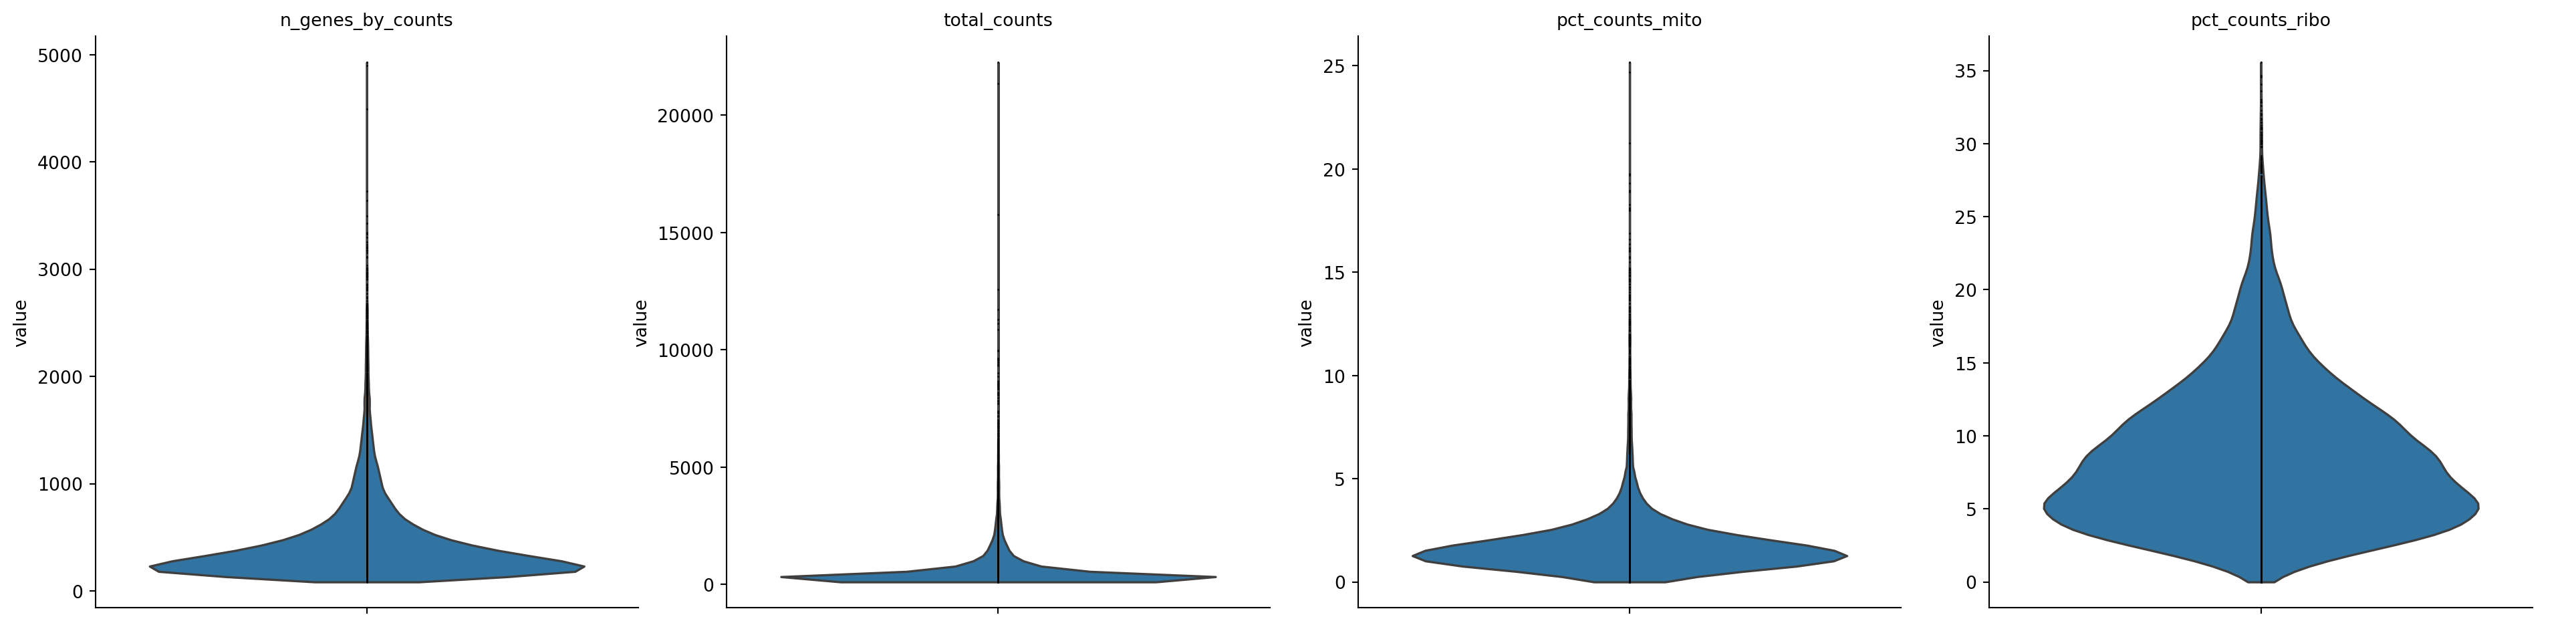

In [6]:
#| label: fig-general
#| fig-cap: "General quality plots for specified fields"
general_quality_plot(adata, sample_field, percent_mito_field, percent_ribo_field)

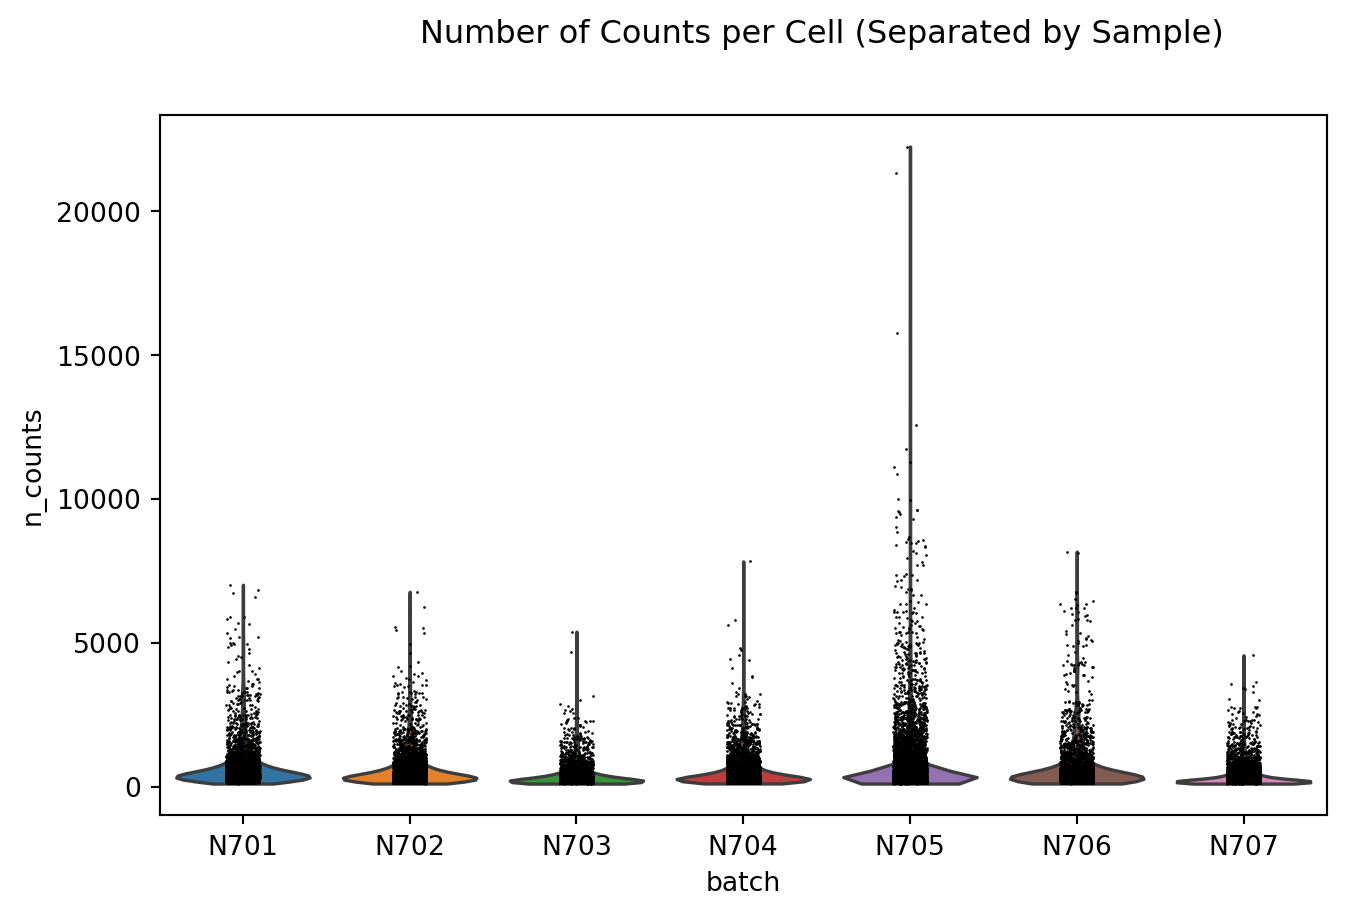

In [7]:
#| label: fig-n-counts
#| fig-cap: "Number of Counts per Cell (Separated by Sample)"
plot_n_counts_per_cell(adata, sample_field)

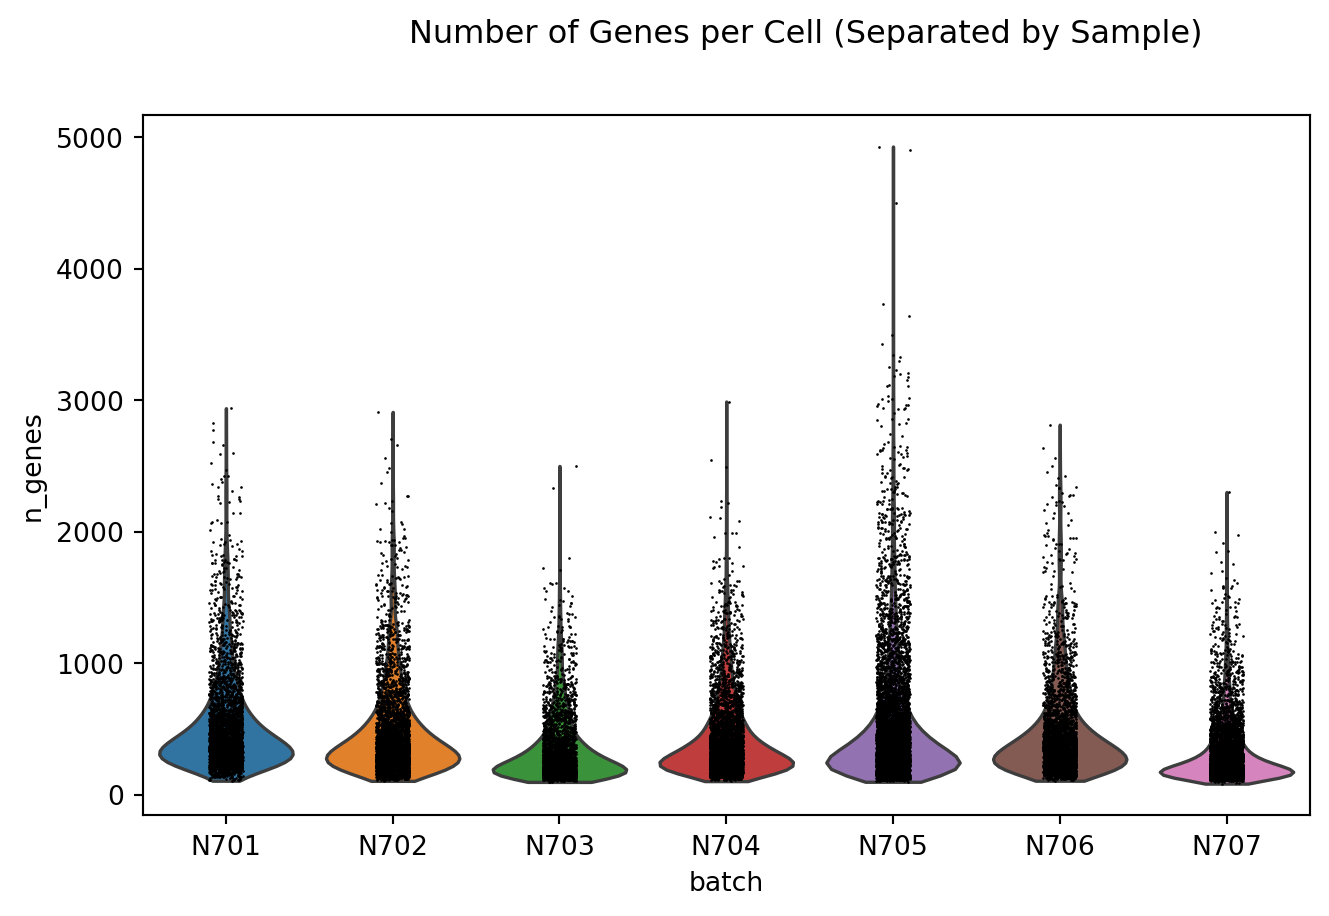

In [8]:
#| label: fig-n-genes
#| fig-cap: "Number of Genes per Cell (Separated by Sample)"
plot_n_genes_per_cell(adata, sample_field)

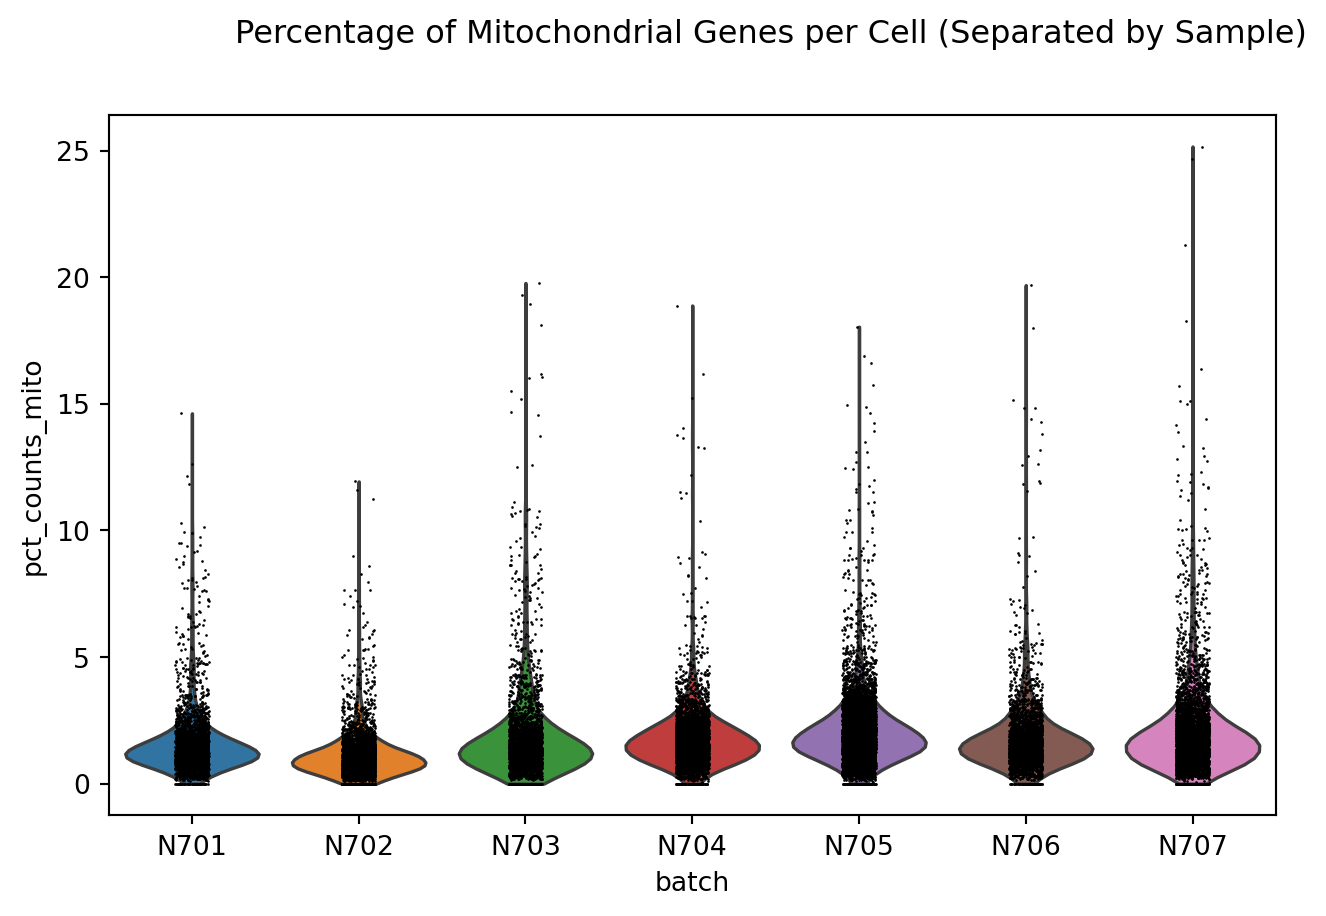

In [9]:
#| label: fig-percent-mito
#| fig-cap: "Percentage of Mitochondrial Genes per Cell (Separated by Sample)"
plot_percent_mito_per_cell(adata, sample_field, percent_mito_field)

In [10]:
#| label: fig-percent-ribo
#| eval: expr percent_ribo_field is not None
#| fig-cap: "Percentage of Ribosomal Genes per Cell (Separated by Sample)"
plot_percent_ribo_per_cell(adata, sample_field, percent_ribo_field)

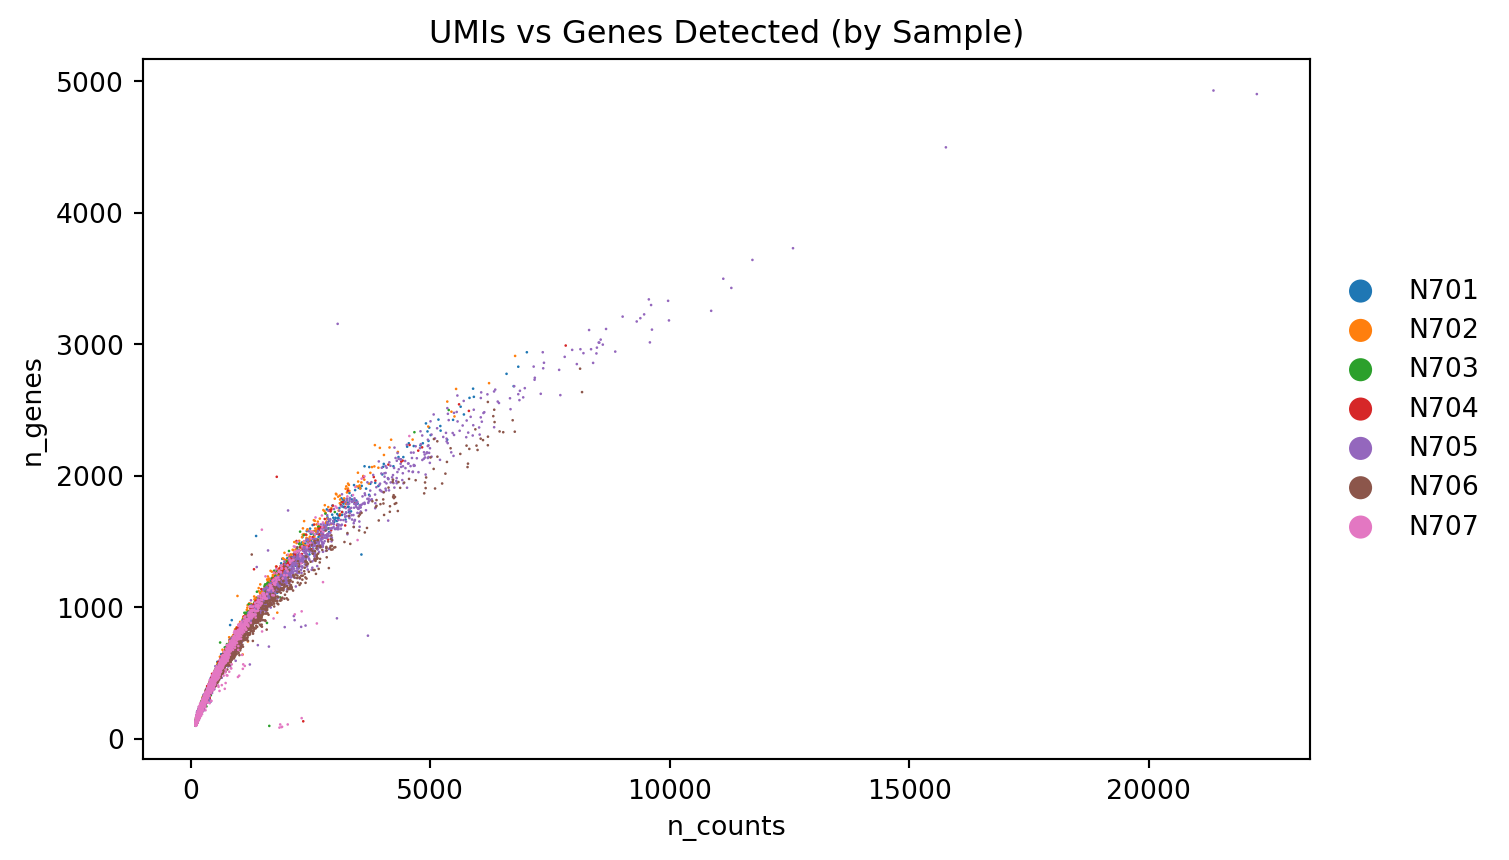

In [11]:
#| label: fig-scatter-sample
#| fig-cap: "UMIs vs Genes Detected (by Sample)"
scatter_plot_by_sample(adata, sample_field)

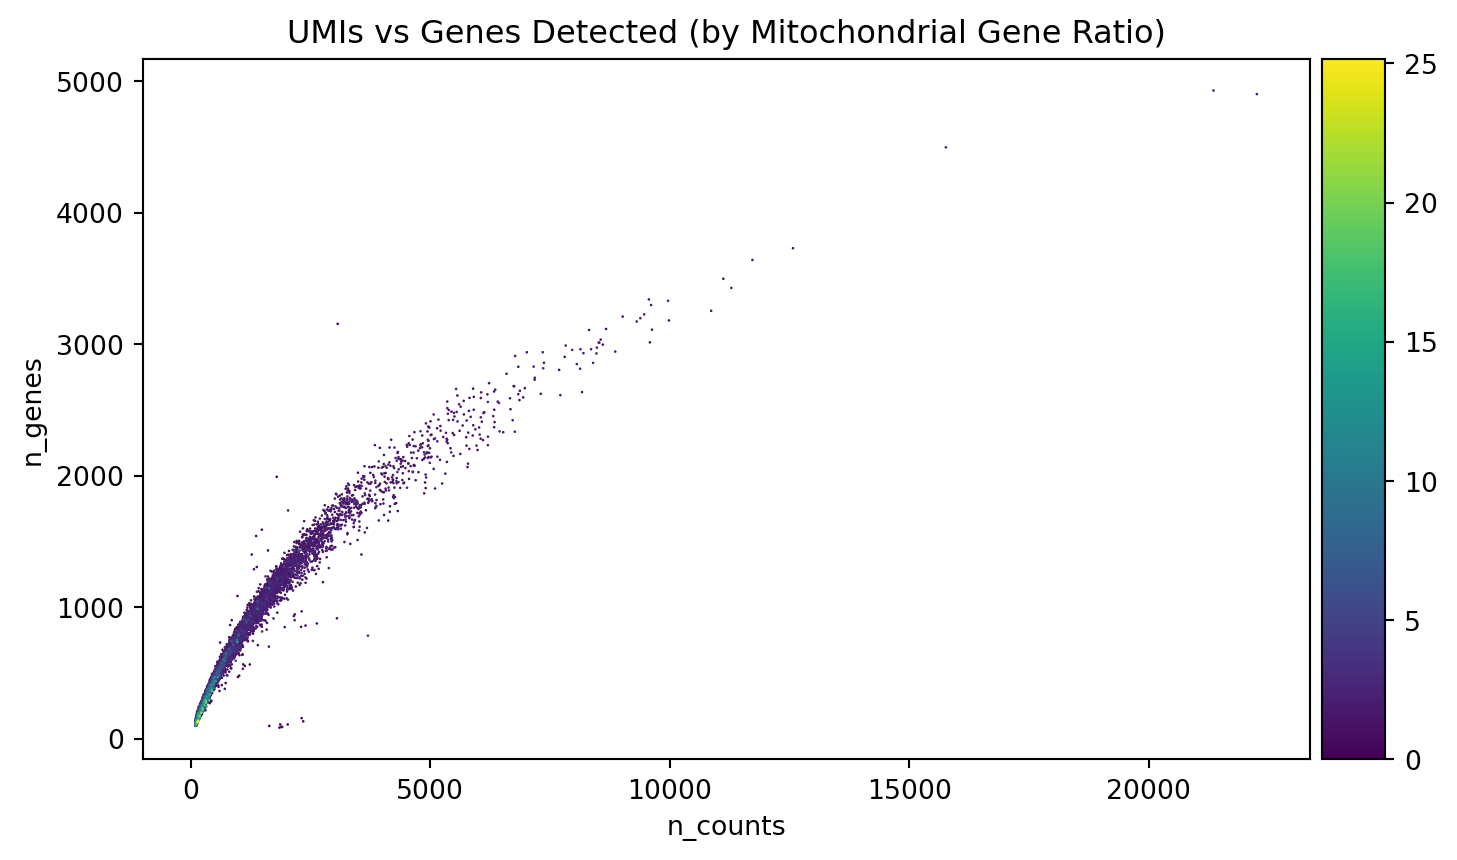

In [12]:
#| label: fig-scatter-mito
#| fig-cap: "UMIs vs Genes Detected (by Mitochondrial Gene Ratio)"
scatter_plot_by_mito_ratio(adata, percent_mito_field)

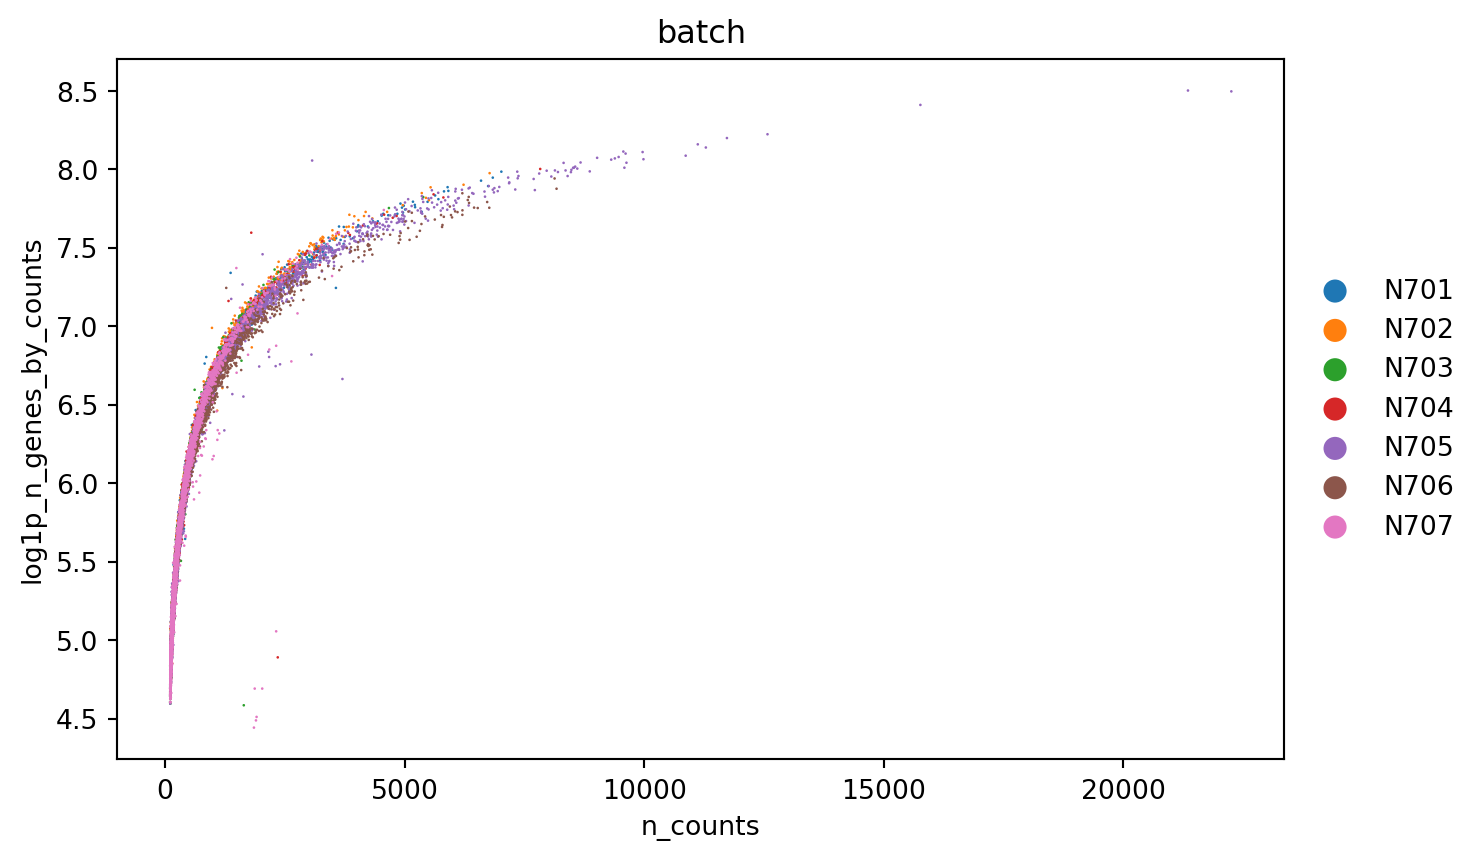

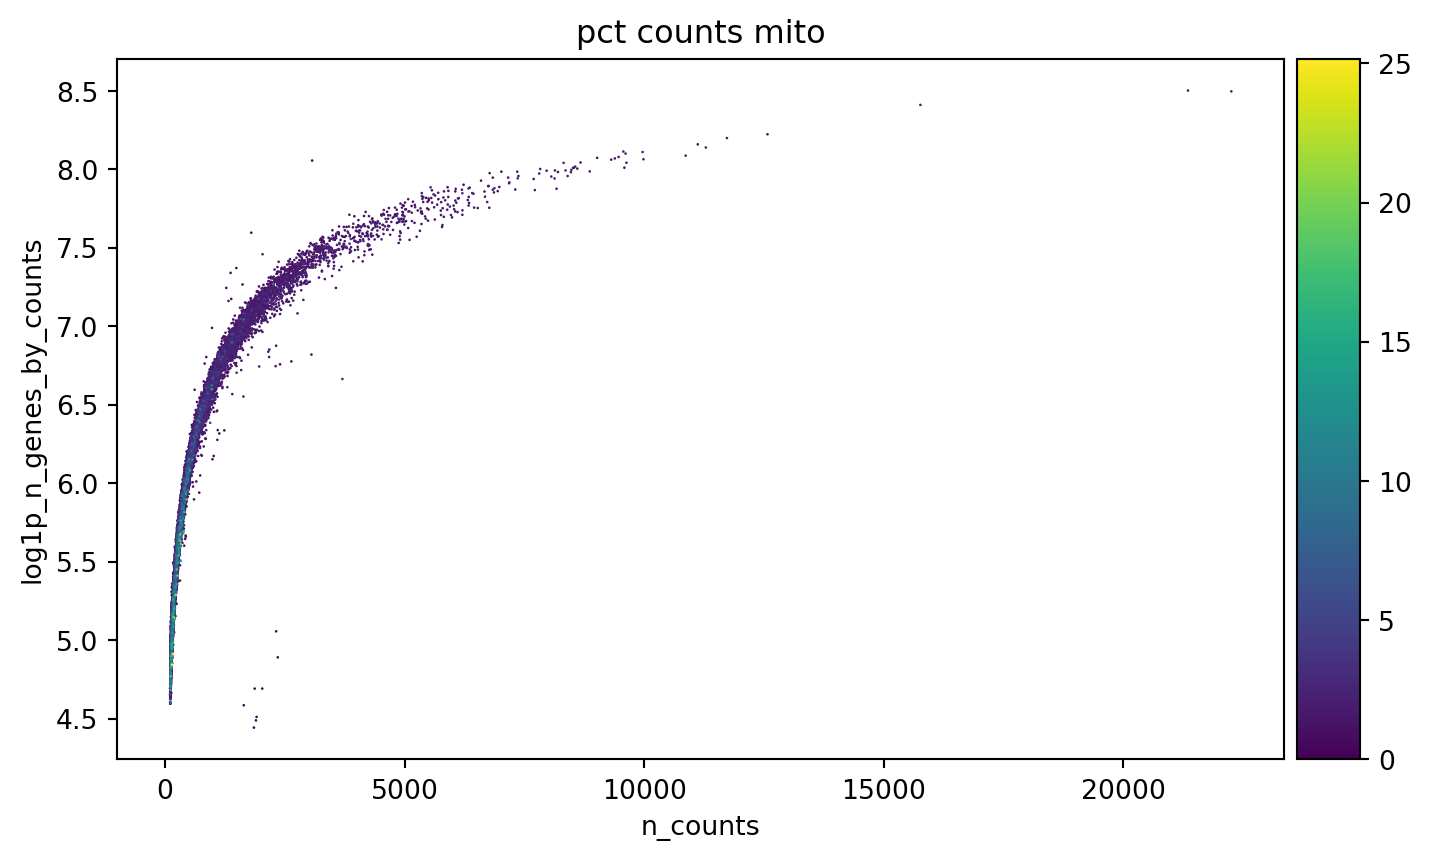

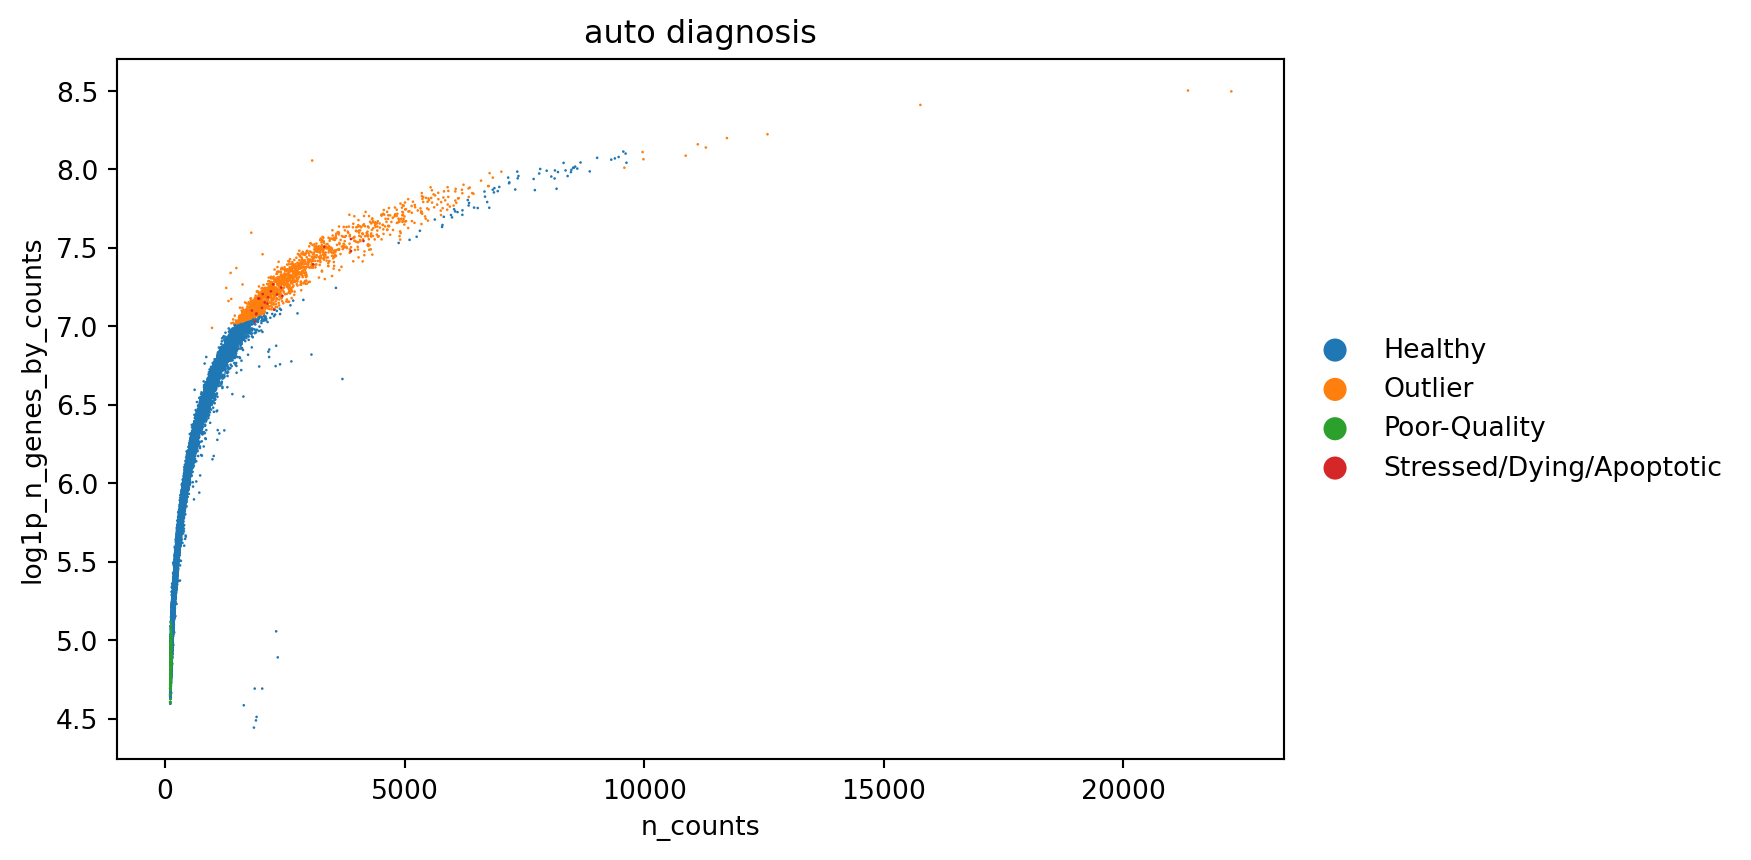

In [13]:
#| label: fig-scatter-diagnosis
#| layout-ncol: 1
#| fig-cap: "Diagnosis"
#| fig-subcap:
#|   - "UMIs vs Genes Detected (by Sample)"
#|   - "UMIs vs Genes Detected (by Mitochondrial Gene Ratio)"
#|   - "UMIs vs Genes Detected (by Mitochondrial Gene Ratio)"

y='log1p_n_genes_by_counts'
sc.pl.scatter(
        adata,
        x="n_counts",
        y=y,
        color=sample_field,
        show=True,
    )

# UMIs vs genes detected scatterplot, colored by mitochondrial gene ratio
sc.pl.scatter(
    adata,
    x="n_counts",
    y=y,
    color=percent_mito_field,
    show=True,
)

sc.pl.scatter(
    adata,
    x='n_counts',
    y=y,
    color='auto_diagnosis',
    show=True
    )

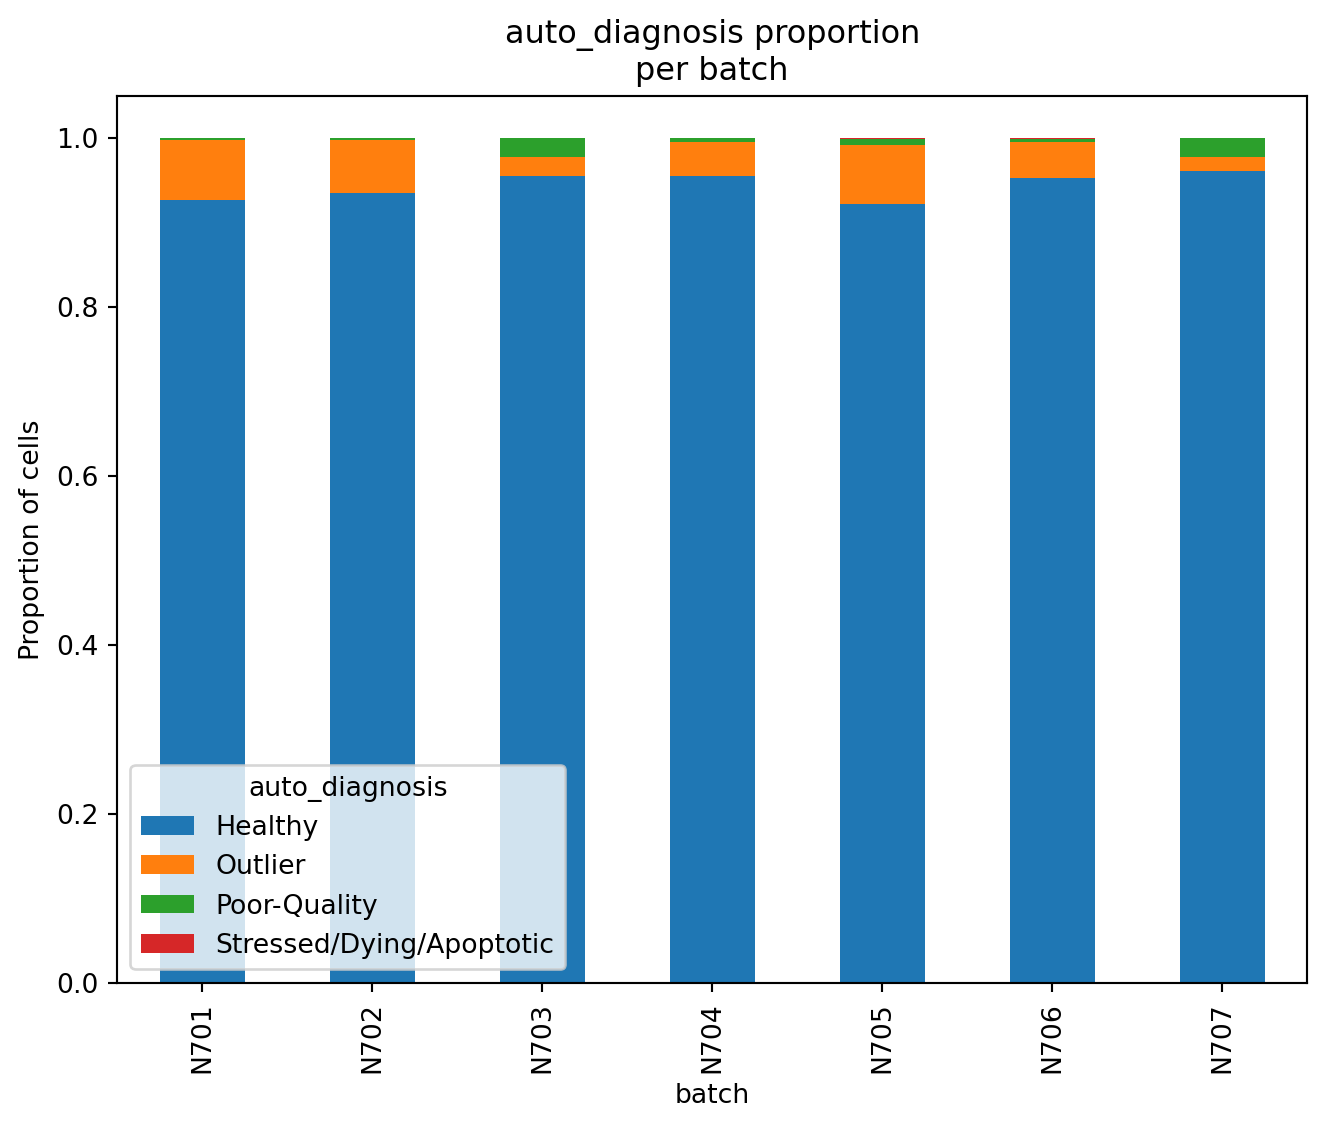

In [14]:
#| label: fig-barplot-diagnosis
#| fig-cap: "Diagnosis composition per sample"
generateProportionalBarPlot(
    adata, groups_field=sample_field, props_field='auto_diagnosis', topic_for_title=None
)